# Example: Grid Analysis Results

Last Verified to Run: 2021-07-07<br>
Verified Stack Release: v21.0.0

## Introduction

The purpose of this notebook is to demonstrate the methodology behind the sensor distortion analysis using an dataset of projected spot grid images, as well as to serve as a tutorial for exploring these results by interacting with a Gen 3 Repository. The data products shown here were generated by running the `mixcoatl.characterizeSpots.CharacterizeSpotsTask`, `mixcoatl.gridFitTask.GridFitTask`, and `mixcotal.gridCalibrationTask.GridCalibrationTask`, using the pipetask YAML file `gridAnalysis.yaml` found in `mixcoatl/pipelines`.

In [1]:
# This should match the verified version listed at the start of the notebook
! eups list -s lsst_distrib

   21.0.0-2-g8e5b5ee+8459b0669c 	w_2021_20 w_latest current setup


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
import numpy as np

## DM Stack imports
from lsst.daf.butler import Butler

## Gen 3 repo (spot grid image data only)
repo = '/sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft/butler.yaml'

## 0. Exploring a Gen 3 Repository

A Butler object can be initialized using the filepath to the repository YAML file. The LSSTCam BOT Gen 3 repository is located on the SLAC SDF, and is split between a number of smaller repositories.  The repository containing the datasets corresponding to the spot grid data acquisition runs during the nine-raft testing period is located at `/sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft/`. While the Butler itself is used for retrieving a dataset from the repository, the registry is useful for performing queries on datasets, exploring "collections" of datasets, and determining dataset types.

In [3]:
butler = Butler(repo)
registry = butler.registry

Here the registry is used to query all the "collections" within the repository and print a sub-set of relevant collections.

In [4]:
## Display collections in the repository
for collection in registry.queryCollections():
    if 'u/asnyder/' in collection:
        print(collection)

u/asnyder/spot/gridcalibration
u/asnyder/spot/gridcalibration/20210621T230400Z
u/asnyder/spot/e2v_analysis
u/asnyder/spot/e2v_analysis/20210623T223607Z
u/asnyder/spot/e2v_calibration
u/asnyder/spot/e2v_calibration/20210624T202522Z
u/asnyder/spot/e2v_analysis_rerun
u/asnyder/spot/e2v_analysis_rerun/20210625T023014Z
u/asnyder/spots/e2v_calibration_rerun
u/asnyder/spots/e2v_calibration_rerun/20210625T185250Z
u/asnyder/spot/itl_analysis
u/asnyder/spot/itl_analysis/20210707T222218Z


In this notebook we will focus on the collections `u/asnyder/spot/itl_analysis` and `u/asnyder/spot/itl_calibration` that contain the initial grid analysis results and the final grid calibration results respectively.

## 1. Instrument Signature Removal

The first step of the grid analysis is to perform instrument signature removal on all of the `raw` spot grid images, using `lsst.ip.isr.IsrTask`.  In the YAML file `gridAnalysis.yaml` this corresponds to the task configuration under the `isr` subheading.

In [5]:
datasetRefs = list(registry.queryDatasets('postISRCCD', collections='u/asnyder/spot/itl_analysis'))
print('Number of calibrated images: {0}'.format(len(datasetRefs)))

Number of calibrated images: 1600


An example of a single calibrated image is shown below; this run consisted of an analysis of spot grid images where the projected grid was randomly dithered across a single ITL CCD. Because of the nature of the projector optics, the outer regions of the spot grid suffer from vignetting and other optical distortions. In order to make the full grid visible, a symmetric logarithmic color scale is used that is linear between +/- 10 and logarithmic elsewhere.

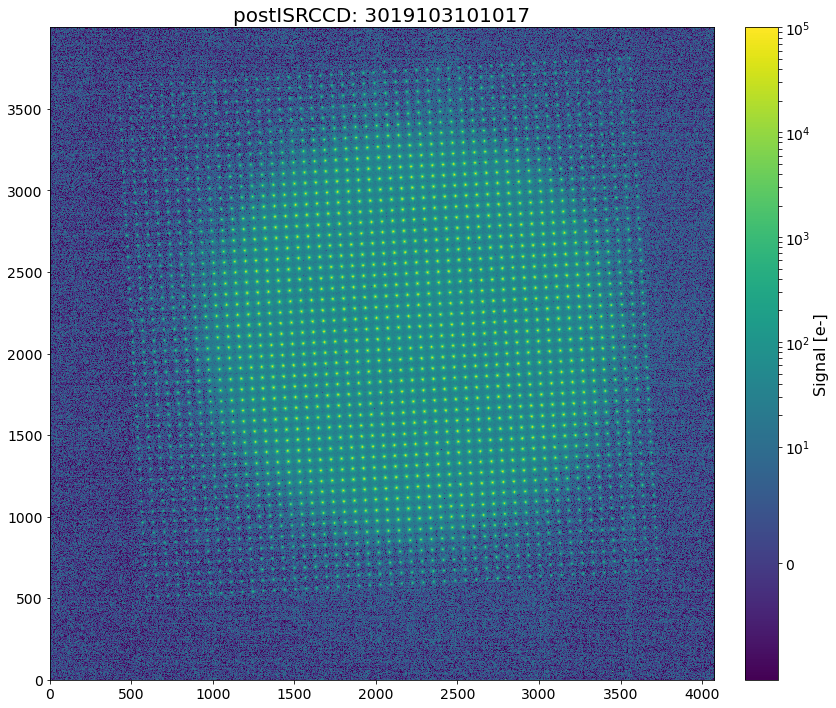

In [6]:
ref = datasetRefs[1000]
calexp = butler.get(ref, collections='u/asnyder/spot/itl_analysis')

## Display calibrated image
fig, ax = plt.subplots(1, 1, figsize=(14, 12))
im = ax.imshow(calexp.getImage().getArray(), interpolation='none', origin='lower', 
               norm=SymLogNorm(10, vmin=-10, vmax=100000, base=10))
    
cbar = fig.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label('Signal [e-]', fontsize=16)
cbar.ax.tick_params(labelsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_title('postISRCCD: {0}'.format(ref.dataId['exposure']), fontsize=20)
fig.patch.set_facecolor('white')

## 2. Spot Identification and Measurement

The second step of the grid analysis is to run a source detection algorithm to identify each spot and to measure its properties such as position, shape, and flux, using the `mixcoatl.characterizeSpots.CharacterizeSpotsTask`. In the YAML file gridAnalysis.yaml this corresponds to the task configuration under the `characterizeSpots` subheading.

What distinguishes this specific source detection algorithm from the `lsst.pipe.tasks.characterizeImage.CharacterizeImageTask` used in the main image analysis pipeline is that no effort is made to subtract the scattered light background. This is because the projector optics result in a scattered light background that rapidly varies spatially (as demonstrated in the above calibrated exposure) and is difficult to subtract properly without leaving large residuals. Additionally, peak finding is performed using a simplified algorithm that uses a maximum filter to identify local maxima.

The results of this analysis step is a catalog of sources of dataset type `spotSrc`, that contains information, in a number of columns, corresponding to different properties of the identified sources.  Below, the detected sources from the calibrated exposure in Step 1 are plotted by position using the SDSS algorithm for position and moment measurements by selecting the `base_SdssCentroid_y` and `base_SdssCentroid_x` columns from the output catalog.

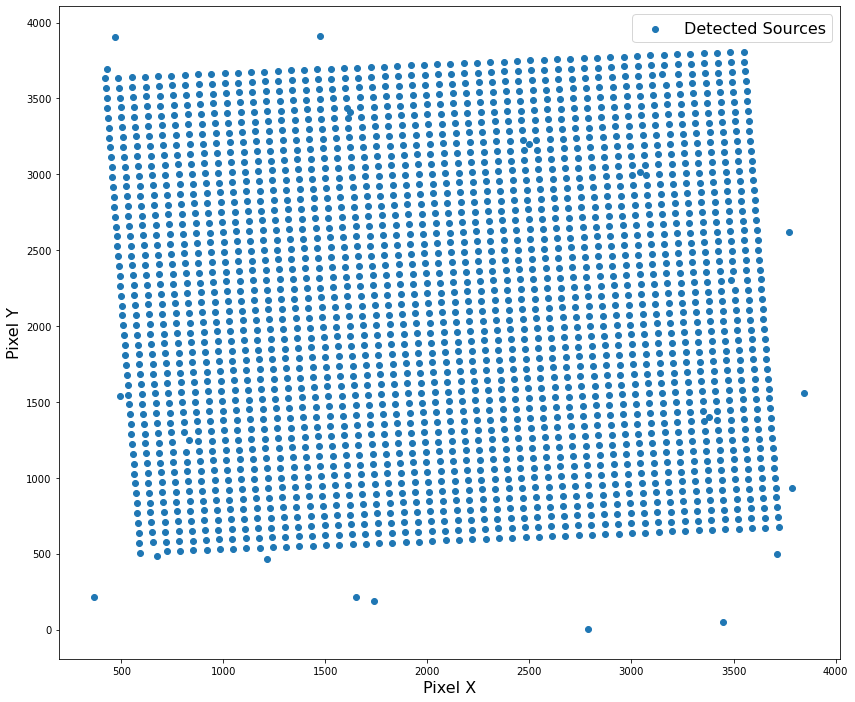

In [7]:
catalog = butler.get('spotSrc', dataId=ref.dataId, collections='u/asnyder/spot/itl_analysis')

src_y = catalog['base_SdssCentroid_y']
src_x = catalog['base_SdssCentroid_x']

fig, ax = plt.subplots(1, 1, figsize=(14, 12))
ax.scatter(src_x, src_y, label='Detected Sources')
ax.legend(fontsize=16)
ax.set_ylabel('Pixel Y', fontsize=16)
ax.set_xlabel('Pixel X', fontsize=16)
fig.patch.set_facecolor('white')

## 3. Grid Fitting

The third step of the grid analysis is to match the identified spots (after rejection of outliers) to an ideal grid that corresponds to the known size of the projected spot grid and to perform a model fit to determine the projected grid parameters such as column/row spacing, rotation, and position of the grid center.  This is done using the `mixcoatl.gridFitTask.GridFitTask` that processes the source catalogs from Step 2, corresponding to the task configuration under the `gridFit` subheading.

The results of the analysis step are a new set of source catalogs of dataset type `gridSpotSrc` that are identical to the original source catalogs of dataset type `spotSrc` except they now contain a new columns indicating which (if any) of the ideal grid sources each identified source corresponds to and its displacement from the ideal.  The catalog metadata also contains information about the grid parameters of the ideal grid model that is best fit to the data.

For a 49 by 49 grid of spots, there are a total number of 2401 spots, indexed 0 through 2400. If an identified source in the original catalog is matched to one of these sources, the corresponding index will be included in the column `spotgrid_index`.  Below, all of the identified sources that have an appropriate value in the `spotgrid_index` in the new catalog are plotted by their positions.

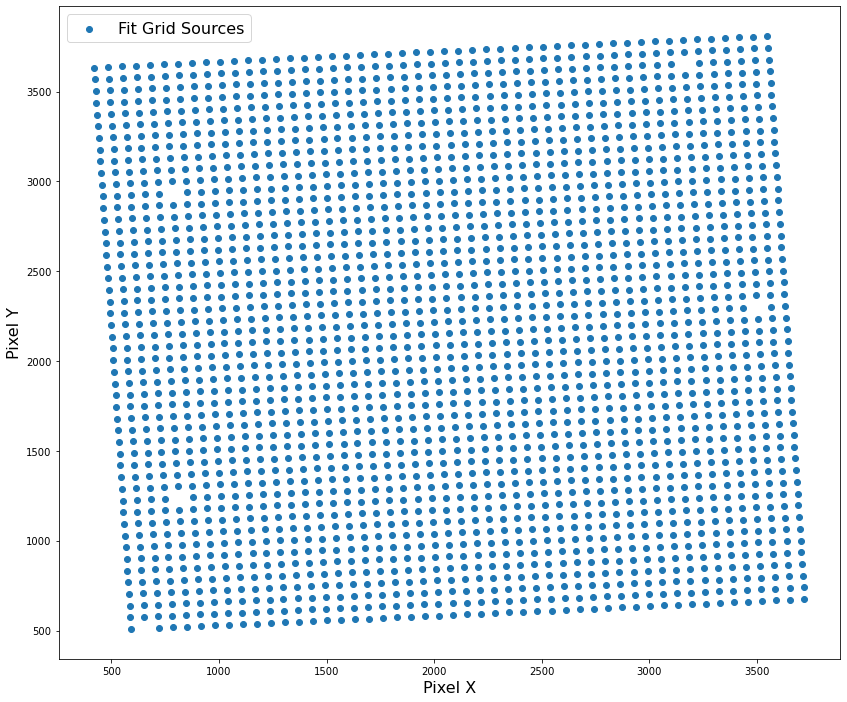

In [8]:
fit_catalog = butler.get('gridSpotSrc', dataId=ref.dataId, collections='u/asnyder/spot/itl_analysis')

select = fit_catalog['spotgrid_index'] >= 0.

fit_src_y = fit_catalog['base_SdssCentroid_y'][select]
fit_src_x = fit_catalog['base_SdssCentroid_x'][select]

fig, ax = plt.subplots(1, 1, figsize=(14, 12))
ax.scatter(fit_src_x, fit_src_y, label='Fit Grid Sources')
ax.legend(fontsize=16)
ax.set_ylabel('Pixel Y', fontsize=16)
ax.set_xlabel('Pixel X', fontsize=16)
fig.patch.set_facecolor('white')

## 4. Grid Calibration

The final step is to determine the mean offset of each spot from the ideal grid position.  The mask used for the projection of the grid of spots is rectilinear, but the projected image becomes distorted by the projector optics and by sensor effects at specific locations of the CCD. The first order distortions of the ideal grid are to magnify the grid in the X/Y, increasing the spacing between rows and columns, as well as to rotate the grid.  These parameters are included in the ideal grid model that is fit to each image. The second order distortions include the shifting of each source from its ideal position from the rotated, dilated ideal grid.

Because the optical distortions are constant between dithers, by taking a per spot average of the spots displacement from the ideal grid model position across all images in the dataset, the position dependent sensor effects are averaged to zero.